### **Importing Libraries and required data**

In [1]:
import os 
import pandas as pd
import numpy as np

Selecting patients with MGMT status available in t1_t2_flair_t1gd 

In [2]:
# Loading t1_t2_flair_t1gd data
df_t1_t2 = pd.read_csv("../Extracted feat combined/t1_t2_flair_t1gd.csv")
df_t1_t2.drop(['Unnamed: 0'], axis=1,inplace=True)

# Loading Clinical Info
df_mgmt_survival = pd.read_csv("../UPENN-GBM_clinical_info_v1.0.csv")
df_mgmt_survival.rename(columns={'ID':'SubjectID'}, inplace=True)  # Renaming ID to SubjectID

# Merging the above two CSV's
df_t1_t2_survival = df_t1_t2.merge(df_mgmt_survival[['Survival_from_surgery_days','SubjectID']], on='SubjectID', how='right')
df_t1_t2_survival.rename(columns={'Survival_from_surgery_days':'Survival_days'}, inplace=True)
df_t1_t2_survival = df_t1_t2_survival.dropna(axis=0)

print("Shape of the dataframe" + str(df_t1_t2_survival.shape))
print("Column names:{}".format(df_t1_t2_survival.columns))
# df_1 = df_t1_t2[df_t1_t2['MGMT'] == 'Unmethylated']
# df_2 = df_t1_t2[df_t1_t2['MGMT'] == 'Methylated']
# df_t1_t2 = pd.concat([df_2,df_1])
# print("df_t1_t2.shape after selecting only available mgmt" + str(df_t1_t2.shape))

Shape of the dataframe(598, 1730)
Column names:Index(['SubjectID', 'T1_ED_Intensity_CoefficientOfVariation',
       'T1_ED_Intensity_Energy', 'T1_ED_Intensity_InterQuartileRange',
       'T1_ED_Intensity_Kurtosis', 'T1_ED_Intensity_Maximum',
       'T1_ED_Intensity_Mean', 'T1_ED_Intensity_MeanAbsoluteDeviation',
       'T1_ED_Intensity_Median', 'T1_ED_Intensity_MedianAbsoluteDeviation',
       ...
       'T1GD_NC_GLSZM_Bins-16_Radius-1_ZoneSizeNonUniformity',
       'T1GD_NC_GLSZM_Bins-16_Radius-1_ZoneSizeNoneUniformityNormalized',
       'T1GD_NC_GLSZM_Bins-16_Radius-1_ZoneSizeVariance',
       'T1GD_NC_NGTDM_Busyness', 'T1GD_NC_NGTDM_Coarsness',
       'T1GD_NC_NGTDM_Complexity', 'T1GD_NC_NGTDM_Contrast',
       'T1GD_NC_NGTDM_Strength', 'T1GD_NC_LBP_Radius-1_Bins-16_LBP',
       'Survival_days'],
      dtype='object', length=1730)


In [3]:
# Removing the data containing label Not available
df_t1_t2_survival=df_t1_t2_survival[df_t1_t2_survival['Survival_days'].isin(['Not Available'])==False]

# Classifing the Survival Days into Short period and Long period
# More than 365 days are long period
# Less than or equals 365 are short period
df_t1_t2_survival['Survival_days']=df_t1_t2_survival['Survival_days'].apply(lambda x: 'long' if int(x)>365 else 'short')

# Converting long and short labels to 1 and 0 simultaneosly
df_t1_t2_survival['Survival_days']=df_t1_t2_survival['Survival_days'].apply(lambda x: 1 if x=='long' else 0)


Long is classified as 1

Short is classified as 0

In [4]:
# Value couts of labels
df_t1_t2_survival['Survival_days'].value_counts()

0    223
1    221
Name: Survival_days, dtype: int64

The data we got is perfectly balanced

### **Train Test Split**

In [5]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_t1_t2_survival.drop(['Survival_days','SubjectID'],axis=1), 
                                                    df_t1_t2_survival['Survival_days'], test_size=0.20, 
                                                    random_state=100, 
                                                    stratify=df_t1_t2_survival['Survival_days'])
print("train size - " + str(train_x.shape))
print("test size - " + str(test_x.shape))

train size - (355, 1728)
test size - (89, 1728)


### **Feature Selection**

#### **Variance Threshold**

In [6]:
### Reducing features using Variance Threshold
threshold=0.4
low_var_col= [x for x in train_x.columns if train_x[x].var()<threshold]
train_x.drop(low_var_col,axis=1,inplace=True)
test_x.drop(low_var_col,axis=1,inplace=True)

#### **Variance Threshold**

In [7]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

correlated_idx=correlation(train_x,0.85)
train_x.drop(correlated_idx,axis=1,inplace=True)
test_x.drop(correlated_idx,axis=1,inplace=True)
train_x.shape

(355, 307)

#### **RFECV using SVM**

In [8]:
# Function for rfecv
from sklearn.feature_selection import RFE,RFECV
def rfe_feature_selection(algo,X,y,cv):
  rfe=RFECV(estimator=algo,cv=cv,min_features_to_select=20)
  rfe.fit(X,y)
  rfe_sel_index=rfe.get_support(indices=True)
  return rfe_sel_index

#### **Feature Scaling**

In [9]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
x_scaled = StandardScaler().fit(train_x)
train_x_scaled = x_scaled.transform(train_x)
test_x_scaled=x_scaled.transform(test_x)

#### **Feature Importance using Buruto**

In [10]:
import xgboost as xgb
import lightgbm as lgb
from boruta import BorutaPy
xgb_model=xgb.XGBClassifier()
feat_sel_boruta=BorutaPy(xgb_model,n_estimators='auto',verbose=0,random_state=1)
feat_sel_boruta.fit(train_x_scaled,train_y)
boruta_rank=feat_sel_boruta.ranking_
boruta_rank

array([ 58, 287,  33, 115, 158, 177, 200, 177, 131, 112,  40,   7,  64,
       200, 264,  12,  29, 287,  92, 245,  74, 158,  67, 245, 158, 200,
       200, 158, 245, 287, 158,  36,  19, 108, 200, 200, 245,  15, 287,
        60,  76,  10, 129, 133, 287,  88, 101, 200,  84, 177,   2, 245,
       200,  50, 200,  53, 245,  83, 229, 224, 106,  27,  55, 158, 200,
        43, 287, 108,  45, 245, 224,  62, 132, 177,  41,  61,  23, 200,
       264, 126, 139, 110, 200, 245, 158, 134, 123, 264,  59,  21,  20,
       287, 111,  67,  57,  11,  31,  51,  30,  16, 287,  23,   1,   8,
       139, 245, 200,  79, 287, 224, 287, 224, 200, 264, 125, 200, 143,
       105, 200,  17,  38, 158,  53,   5,  67, 177, 287,  25, 245, 224,
       113, 200, 100, 245, 200,  56,  13, 136, 128, 158,  18, 118, 102,
       177, 158,  92,  39,   9, 117, 245, 287, 287,  75, 114,  89,  77,
        64,   1, 287, 144, 287, 200, 200,   4,  34, 158, 177, 200,  81,
        98, 200, 158, 200, 245, 287, 142, 158, 287, 200, 158,  2

In [11]:
col_dict_rank=dict(zip(train_x.columns,boruta_rank))
boruta_sel_col=[col for col in col_dict_rank.keys() if col_dict_rank[col]<=45]
boruta_train_x=train_x[boruta_sel_col]
boruta_test_x=test_x[boruta_sel_col]

boruta_x_scaled = StandardScaler().fit(boruta_train_x)
boruta_train_x_scaled = boruta_x_scaled.transform(boruta_train_x)
boruta_test_x_scaled=boruta_x_scaled.transform(boruta_test_x)

In [12]:
len(boruta_sel_col)

46

#### **SVM**

In [26]:
from sklearn.svm import SVC
svc=SVC(kernel='rbf',C=0.1)
svc.fit(boruta_train_x_scaled,train_y)
svc.score(boruta_test_x_scaled,test_y)

0.6629213483146067

#### **Naive Bayes**

In [14]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(boruta_train_x_scaled,train_y)
gnb.score(boruta_test_x_scaled,test_y)

0.5280898876404494

#### **Logistic Regression**

In [15]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(boruta_train_x_scaled,train_y)
lr.score(boruta_test_x_scaled,test_y)

0.5842696629213483

#### **KNN**

0.6966292134831461


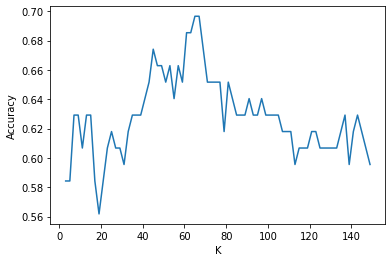

In [16]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn_score=[]
for k in range(3,150,2):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(boruta_train_x_scaled,train_y)
    knn_score.append(knn.score(boruta_test_x_scaled,test_y))

# print(knn_score)
print(max(knn_score)) 
plt.plot(range(3,150,2),knn_score)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

#### **Bagging Classifier**

In [17]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier
# clf_svc = BaggingClassifier(estimator=[DecisionTreeClassifier(),SVC()],n_estimators=500, random_state=0)
# clf_svc.fit(boruta_train_x_scaled,train_y)
# clf_svc.score(boruta_test_x_scaled,test_y)

In [18]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# lr=LogisticRegression()
# knn=KNeighborsClassifier(n_neighbors=7)
# svc=SVC(kernel='linear')
# rfecv_feat_idx=rfe_feature_selection(svc,boruta_train_x_scaled,train_y,20) # Getting features using RFECV 
# rfecv_feat_idx

In [19]:
boruta_train_x_scaled

array([[ 0.13611746, -0.5125357 , -0.01274214, ..., -0.06540904,
        -0.28185822,  0.10565674],
       [-0.33282795, -0.24443623, -0.23998032, ..., -0.30116225,
         0.50620203, -0.60395731],
       [-0.06477808, -0.5125357 , -0.2541827 , ...,  1.863033  ,
        -0.81275354,  1.81419516],
       ...,
       [-0.13857113, -0.55721895, -0.2612839 , ..., -0.2457562 ,
         0.62085326, -0.13687087],
       [-0.03606533, -0.46785246, -0.13346242, ...,  1.75403968,
        -1.13896679, -0.26815284],
       [-0.44445877, -0.49019408, -0.10150705, ..., -0.91258079,
        -0.85923184,  0.62919062]])

In [81]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
k_folds=10
skfold=StratifiedKFold(n_splits=k_folds,random_state=10,shuffle=True)
# sel_train_x=np.take(boruta_train_x_scaled,rfecv_feat_idx,axis=1)
# sel_test_x=np.take(boruta_test_x_scaled,rfecv_feat_idx,axis=1)
metrics=[]
for train_idx,val_idx in skfold.split(boruta_train_x_scaled,train_y):
    x_train = np.take(boruta_train_x_scaled,train_idx,axis=0) # This train is the train set in validation
    x_val = np.take(boruta_train_x_scaled,val_idx,axis=0)
    y_train = np.take(train_y,train_idx,axis=0)
    y_val = np.take(train_y,val_idx,axis=0)
    # model_svc=SVC(kernel='poly',C=1)
    model_svc=SVC(kernel='rbf',C=0.1)
    model_svc.fit(x_train,y_train)
    pred_val_y=model_svc.predict(x_val)
    pred_test_y=model_svc.predict(boruta_test_x_scaled)
    metrics.append([model_svc.score(x_train,y_train),accuracy_score(y_val,pred_val_y),
                    accuracy_score(test_y,pred_test_y)])

In [82]:
df_metrics=pd.DataFrame(data=metrics,columns=['train','val','test'])
df_metrics

,train,val,test
0,0.724138,0.722222,0.640449
1,0.686520,0.638889,0.629213
2,0.708464,0.583333,0.640449
3,0.711599,0.666667,0.640449
4,0.683386,0.500000,0.674157
5,0.671875,0.657143,0.651685
6,0.665625,0.657143,0.640449
7,0.678125,0.542857,0.651685
8,0.703125,0.600000,0.617978
9,0.715625,0.485714,0.629213


In [83]:
metrics=np.array(metrics)
avg_accuracy=df_metrics.test.mean()
std_accuracy=df_metrics.test.std()
print("Accuracy : "+str(avg_accuracy)+" +/- "+str(std_accuracy))

Accuracy : 0.6415730337078651 +/- 0.015396857521419087
